# Segmentation 3D+T

## 1. Introduction : 
Selon l'Organisation Mondiale de la Santé (OMS), les maladies cardiovasculaires sont la **principale** cause de décès au niveau mondial.
D’après les estimations, 17,9 millions de personnes sont mortes de maladies cardiovasculaires en 2019, soit **32%** de tous les décès dans le monde. Le détection précoce de ces pathologies constitue donc un réel enjeu de santé publique, en particulier dans les pays en voie de dévelopement qui disposent d'un accès très inégal à la santé.

Pour cela, les cliniciens ont besoin d'effectuer des segmentations des cavités cardiaques. Ainsi ils peuvent accéder aux caractéristiques du muscle cardiaque comme par exemple son volume, sa masse, la fraction d’éjection…. Cependant, cette tache fastidieuse à effectuer à la main, d’où la nécessité de produire des outils de segmentation semi-automatique voire automatique.

**Etat de l'Art :** Si aujourd'hui des approches basées sur des réseaux convolutifs (U-Net) et des Transformers dominent le sujet grace à leur précision et leur robustesse, la segmentation d'imageries cardiaques existe depuis bien plus longtemps au travers de contours actifs et de croissance de région.

**Objet du projet :** L'objet de notre project est ainsi d'implémenter une méthode de segmentation par croissance de région pour segmenter le ventricule gauche. Pour l'interet scientifique de la chose, nous nous contentons d'utiliser des méthodes "au pixel".

## 2. Le Dataset

Pour notre projet, nous utilisons le jeu de données ACDC (Automatic Cardiac Diagnosis Challenge) élaboré en 2017 à l'Hopital de Dijon dans le cadre d'un challenge de segmentation. Ce dernier qui offre un ensemble standardisé d'images 3D+T, ainsi que d'annotations utiles pour évaluer les performances de nos méthodes de segmentation.

Présentons ce Dataset dans un premier temps. Constitué de 150 patients, nous avons utilisé les 100 premiers pour l'élaboration de notre code ainsi que nos test récurrents. Les 50 autres n'ont jamais étés touchés jusqu'a lévaluation finale de nos performances sur ces derniers. En effet nous voulions à tout prix éviter des biais d'entrainement et cette partie test joue le role d'un test grandeur nature avec un patient nouveau sur lequel nous n'avons aucune information qui arrive.

-dire ce que contient un patient !

Observons un patient. Pour cela nous importons les bibliothèques nécessaires; nous utiliserons torchio pour visualiser nos images.

In [85]:
import torch
import torchio as tio

import numpy as np
import matplotlib.pyplot as plt
from skimage import measure 
import pandas as pd

import cv2
from collections import deque

from ipywidgets import interact
import ipywidgets as widgets

Puis, chargeons un patient dont on observe une tranche centrale, à l'instant $t=0$.

In [86]:
Tps = 0 #instant temporel d'observation
Slice = 11//3 #coupe à observer
Numero_patient = 2 # numéro du patient à observer

def load_patient(num, testing=False):
    path='database/training'
    if testing:
        path = 'database/testing'
        num+=100
    # load the dict of information on the patient
    with open(path+f'/patient{num:03}/info.cfg') as f:
        info = [line.replace("\n", "").replace(":", "").split(" ") for line in f]
        for i in range(len(info)):
            if info[i][1].isnumeric():
                info[i][1] = int(info[i][1])
    # create the patient object with (4Dimages, grandTrue, information)
    patient = tio.Subject(
        img=tio.ScalarImage(path+f'/patient{num:03}/patient{num:03}_4d.nii.gz'),
        gt=tio.LabelMap(path+f'/patient{num:03}/patient{num:03}_frame{dict(info)["ED"]:02}_gt.nii.gz'),
        info = dict(info)
    )
    return patient

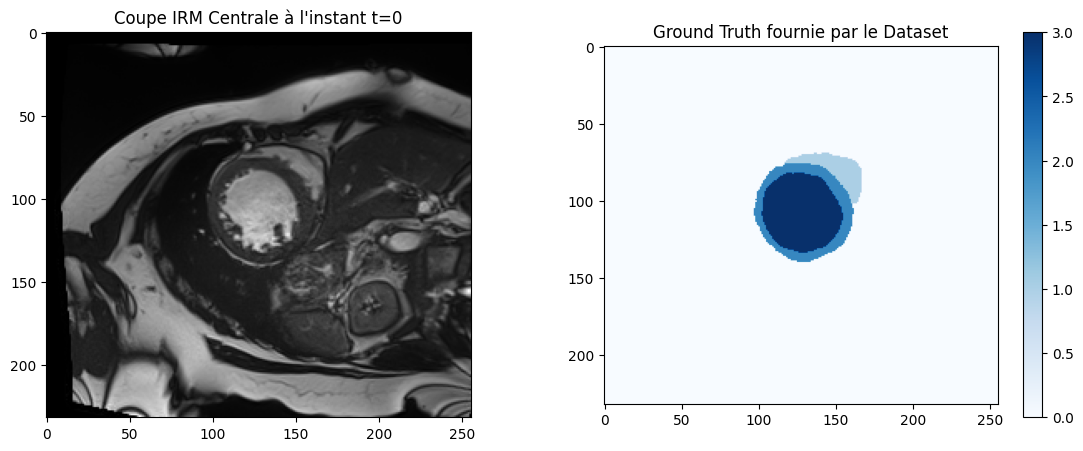

In [87]:
patient = load_patient(Numero_patient)
t_img = patient.img.data.detach()
t_gt = patient.gt.data.detach()

def show_slice(t_img, t_gt, slc, tps):
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    ax[0].imshow(t_img[tps,:,:, slc], cmap='gray')
    ax[0].set_title('Coupe IRM Centrale à l\'instant t=0')
    ax[1].imshow(t_gt[tps,:,:,slc], cmap='Blues')
    ax[1].set_title('Ground Truth fournie par le Dataset')
    fig.colorbar(ax[1].images[0], ax=ax[1], orientation='vertical')
    plt.show()

show_slice(t_img, t_gt, Slice, Tps)

Expliquer ici ce qu'on cherche à segmenter, et comment.

De plus chaque patient possède des informations supplémentaires dans un fichier texte associé. 

On a converti ces informations en un dictionnaire pour les utiliser plus loin.

In [88]:
pd.DataFrame(patient.info.items(), columns=['Attribut', 'Valeur'])

,Attribut,Valeur
0,ED,1
1,ES,12
2,Group,DCM
3,Height,160.0
4,NbFrame,30
5,Weight,70.0


## 3. Placement des Seeds

**La méthode par croissance de région nécessite un point de départ.**

En effet, la croissance de région repose sur **l'expansion** de la region segmentée de manière *itérative*. A chaque étape, les pixels au bord de la région regardent leurs voisins (dans notre code nous avons testés plusieurs choix de voisins différents, nous détaillons cela plus loin) et pour chacun d'entre eux, regardent si la différence d'intensité est inférieure à un seuil.

Ce seuil est crucial pour un bonne segmentation; on comprend aisement que :
    - un seuil trop faible bloque l'expension de la region.
    - un seuil trop grand étend notre région petit à petit à toute l'image. La region segmentée est ainsi bien trop grande par rapport à ce qui est attendu.

Ainsi, il apparait que deux sujets deviennent importants à traiter : 
- Placer le point de départ dans le ventricule gauche.
- Pouvoir choisir un seuil idéal pour chaque image et chaque patient.

Commencons par tenter de placer une seed.

### A. Méthode de Hough : Théorie

En observant les images IRM de patients, nous remarquons que la région que nous souhaitons segmenter est la plupart du temps de forme à peu près ronde. Serait il donc possible de détecter les cercles d'une image, et espérer que le cercle trouvé soit celui qui approxime le ventricule gauche.

Pour cela nous utilisons la méthode de la transformée de Hough Circulaire, qui nous permettra d'identifier la structure circulaire du ventricule gauche et ainsi de placer notre seed au bon endroit.

#### 1. Paramètres.
Un cercle dans un espace géométrique peut être défini par trois paramètres : $a$ et $b$ les coordonnées du centre du cercle et $R$ le rayon de ce cercle. L'équation paramétrique s'écrit alors : $$ x=a+R \ cos(\theta) $$ $$y=b+R \ sin(\theta)$$
où $\theta$ varie sur $[0,2\pi]$

L'idée de la méthode est alors le suivant : parmis les points représentant les contours de l'image, chacun génère une courbe circulaire dans un espace des paramètres $ (a,b,R) $. Ainsi chaque intersection dans cette nouvelle représentation est censée représenter le centre d'un cercle potentiel. 

<center>
    <img src="hough_1.png" alt="Hough 1" style="width:70%;">
</center>

On vote alors dans une matrice dite *d'accumulation* pour toute les intersections proportionnelement au nombre de cercles qui s'y croisent.

#### 2. Cas des cercles de rayon inconnu.
Le cas des cercles de rayon connu, dérive simplement du cas suivant en ne considérant l'opération que dans un espace paramétrique bi-dimensionnel avec un rayon $R$ fixé. Dans le cas des cercles de rayon inconnu :

**Pour chaque rayon $R$ :**
- **Étape 1 :** Chaque point $P(x,y)$ de l'image génère une courbe circulaire de rayon R dans l'espace des paramètres $(a,b)$
- **Etape 2 :** Les intersections des cercles sont sauvegardées dans une matrice d'accumulation. Le maximum de cette matrice fourni un triplet $(a,b,R)$ qui désigne le cercle le plus voté.

*Remarque: pour le cas des rayons inconnus, on peut aussi le voir sous la forme : chaque point $P(x,y)$ génère une surface conique d'axe $(a,b)$.*

<center>
    <img src="hough_2.png" alt="Cones Hough" style="width:30%;">
</center>

#### 3. Prétraitement des Images.

Comme nous l'avons vu, il faut générer un cercle pour chaque pixel de l'image sur laquelle on cherche un cercle. Ainsi pour gagner en efficacité et en compléxité, on cherche le plus souvent à isoler les contours en effectuant diverses opérations : 
- conversion en niveau de gris
- canny edge detector

### B. Hough Naïf : pratique

Utilisons dans un premier temps une implémentation naive, c'est à dire Hough (non codée par nous) sur une image du patient directement.

On choisit le premier instant temporel $t=0$ et la tranche centrale.

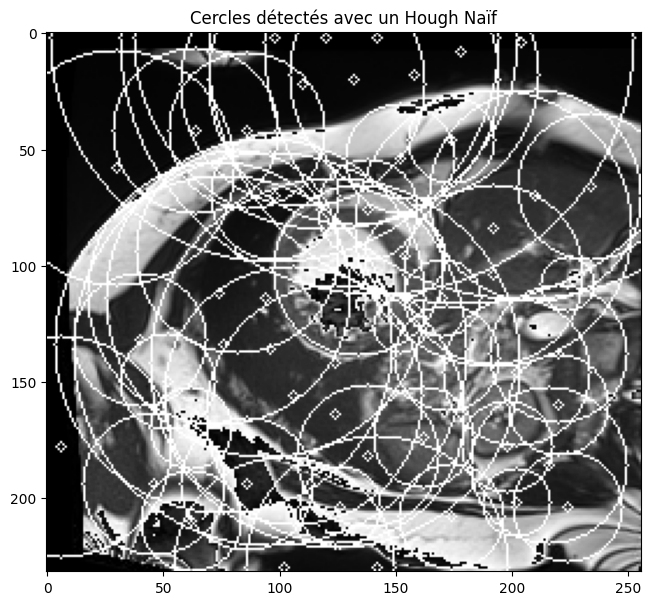

In [89]:
hough_entry = np.array(t_img[Tps, :, :, Slice], dtype=np.uint8) # l'image doit etre convertie en uint8
circles = cv2.HoughCircles(hough_entry, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=80,param2=40,minRadius=1,maxRadius=0) # Hough

fig = plt.figure(figsize=(10,7)) # affichage
plt.imshow(hough_entry, cmap='gray')
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        cv2.circle(hough_entry,(i[0],i[1]),i[2],(255,255,255),1) # on trace l'extérieur du cercle
        cv2.circle(hough_entry,(i[0],i[1]),2,(255,255,255),1) # on trace le point central
plt.imshow(hough_entry, cmap='gray')
plt.title('Cercles détectés avec un Hough Naïf')
plt.show()

On remarque deux choses principales :
- Le nombre de cercles détectés est trop important si on ne restreint pas les paramètres de la fonction de Hough. On va donc devoir agir sur le rayon minimal, maximal, ainsi que les paramètres utilisés pour le canny.
- Les cercles sont répartis sur l'intégralité de l'image. L'idée selon laquelle nous pouvons établir une carte du maximum de vraissemblance parmis de nombreux cercles nous semnble compromise : il nous semble y avoir qu'un seul cercle correctement centré sur le ventricule gauche.

**Cherchons donc une solution.**

### C. Elaboration d'un masque

On propose de définir une fonction `mask` qui va chercher à isoler une meilleure zone en amont de la recherche de cercles. Pour cela, on récupère dans les informations de chaque patient, la fréquence cardiaque au moment de l'IRM :
$$Fréquence \ \ Cardiaque = \frac{L_t}{t_{systole}-t_{dystole}} $$
Où :
- $L_t$ désigne le nombre d'instants temporels du patient étudié
- $t_{systole}-t_{dystole}$ désigne une demi période cardiaque.

Puis on effectue une **transformée de Fourier** de notre image et on ne conserve que la fréquence cardiaque précédemment isolée. 
$$ Masque = TF(image)[Fréquence \ \ Cardiaque]$$

Enfin on obtient après dilatation, errosion et floutage, le masque final qu'on utilise pour chaque patient. 

$$ Masque  \ final = Blur(Erode(Dilate(Masque)))$$

En le multipliant à l'image d'origine, le résultat est une image IRM dont la majeure partie de l'image sauf le coeur est assombrie. Observons cela et l'effet sur la détection de cercles.

<center>
    <img src="creationmask.png" alt="creation mask" style="width:100%;">
</center>


In [90]:
def tf_mask(image4d, Tps=Tps, Slice=Slice, heartrate=2):
    fft_img = torch.fft.fft(image4d, axis=0)
    filtred = fft_img
    # interpolation frequance cardiaque
    heartrate_i = int(heartrate)
    heartrate_f = heartrate - heartrate_i
    filtred[:heartrate_i, :, :, :] = 0.0
    filtred[heartrate_i+1:, :, :, :] = 0.0
    filtred[heartrate_i] *= (1-heartrate_f)
    filtred[heartrate_i+1] *= heartrate_f
    # fft inverse with the filtred input
    timg2 = torch.abs(torch.fft.fft(filtred, axis=0))

    mask = np.array(timg2[Tps, :, :, Slice])
    mask = np.uint8(2*mask/np.max(mask)*255)
    # using morphology to go from a cercle to a disk
    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(110,110)), 1)
    mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(130,130)), 1, borderType=cv2.BORDER_CONSTANT, borderValue=0)
    mask = cv2.blur(mask,(21, 21))
    # combine mask and input
    img_m = np.array(image4d[Tps, :, :, Slice], dtype=np.float64)
    img_m = np.uint8(img_m/np.max(img_m)*np.float64(mask))
    img_m = cv2.medianBlur(img_m,5)
    
    return img_m, mask


Affichons le résultat de l'opération de masquage sur le patient précédent.

On observe bien le résultat souhaité, mais avant de l'appliquer sur notre patient, on va essayer de définir une meilleure implémentation de Hough, qui serait capable d'ajuster les paramètres automatiquement.

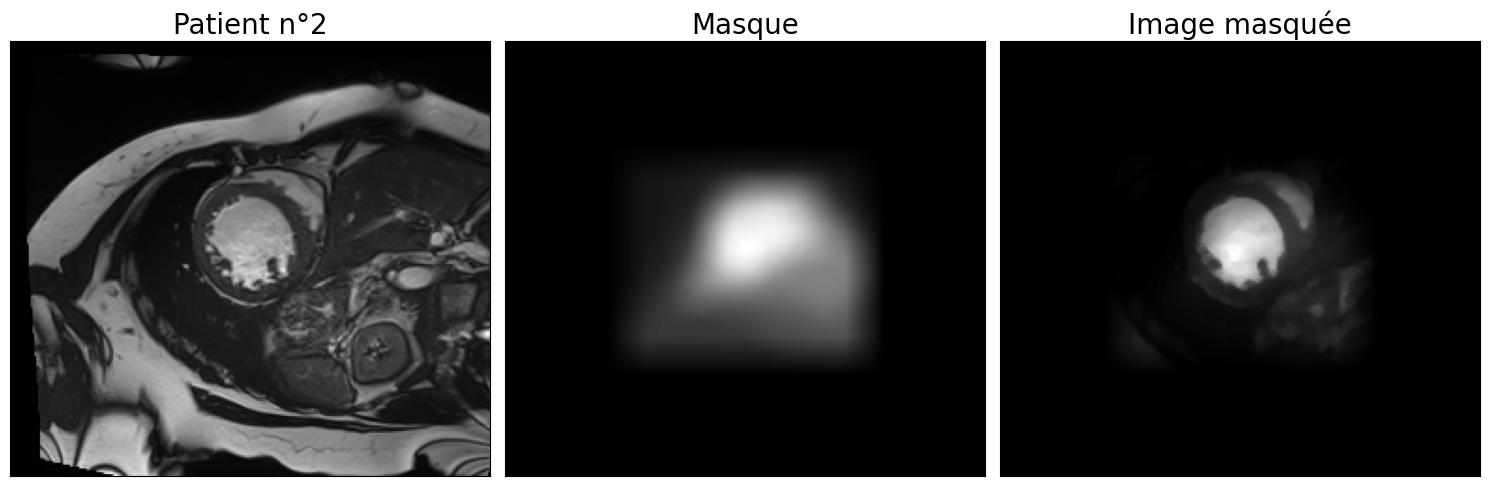

Fréquence Cardiaque du Patient n°2: 2.727272727272727


In [91]:
img_m, mask = tf_mask(t_img, heartrate=t_img.shape[0] / (patient.info["ES"] - patient.info["ED"]))

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(t_img[Tps, :, :, Slice], cmap='gray')
plt.title(f'Patient n°{Numero_patient}', fontsize=20)
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
plt.imshow(mask, cmap='gray')
plt.title('Masque', fontsize=20)
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,3)
plt.imshow(img_m, cmap='gray')
plt.title('Image masquée', fontsize=20)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

print(f"Fréquence Cardiaque du Patient n°{Numero_patient}:" , t_img.shape[0] / (patient.info["ES"] - patient.info["ED"]))

On définit simplement une fonction d'affichage des cercles, afin de pouvoir l'appeler simplement lors des usages suivants.

In [92]:
def to_rgb(gray):
    return cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

def draw_cercles(image4d, circles=None, Tps=Tps, Slice=Slice):
    cimg = np.array(image4d[Tps, :, :, Slice])
    cimg = np.uint8(cimg/np.max(cimg)*255)
    cimg = to_rgb(cimg)
    if circles is not None:
    # print("circles !")
        circles = np.uint16(np.around(circles))
    
        cv2.circle(cimg,(circles[0],circles[1]),circles[2],(0,255,0),1)
        cv2.circle(cimg,(circles[0],circles[1]),1,(255,0,0),2)
    # else:
    # print("no circles !")
    return cimg

### D. Best Hough

Rédiger la partie sur la méthode de Hough améliorée qu'on propose.

De manière générale essayer d'inclure dans tout ce qui précède, plus de schémas, graphiques, etc ... (quoique peut etre dans la partie performances.)

In [93]:
def best_hough(image):
    param_min = 0
    param_max = 200
    for _ in range(12):
        param_mean = (param_min + param_max) / 2
        circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=param_mean,param2=param_mean/2,minRadius=0,maxRadius=0)
        
        if circles is not None and len(circles[0])==1:
            return circles[0][0]
        
        elif circles is None:
            param_max = param_mean
        else:
            param_min = param_mean
    return None

C:\Users\debat\AppData\Local\Temp\ipykernel_12896\629302480.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)


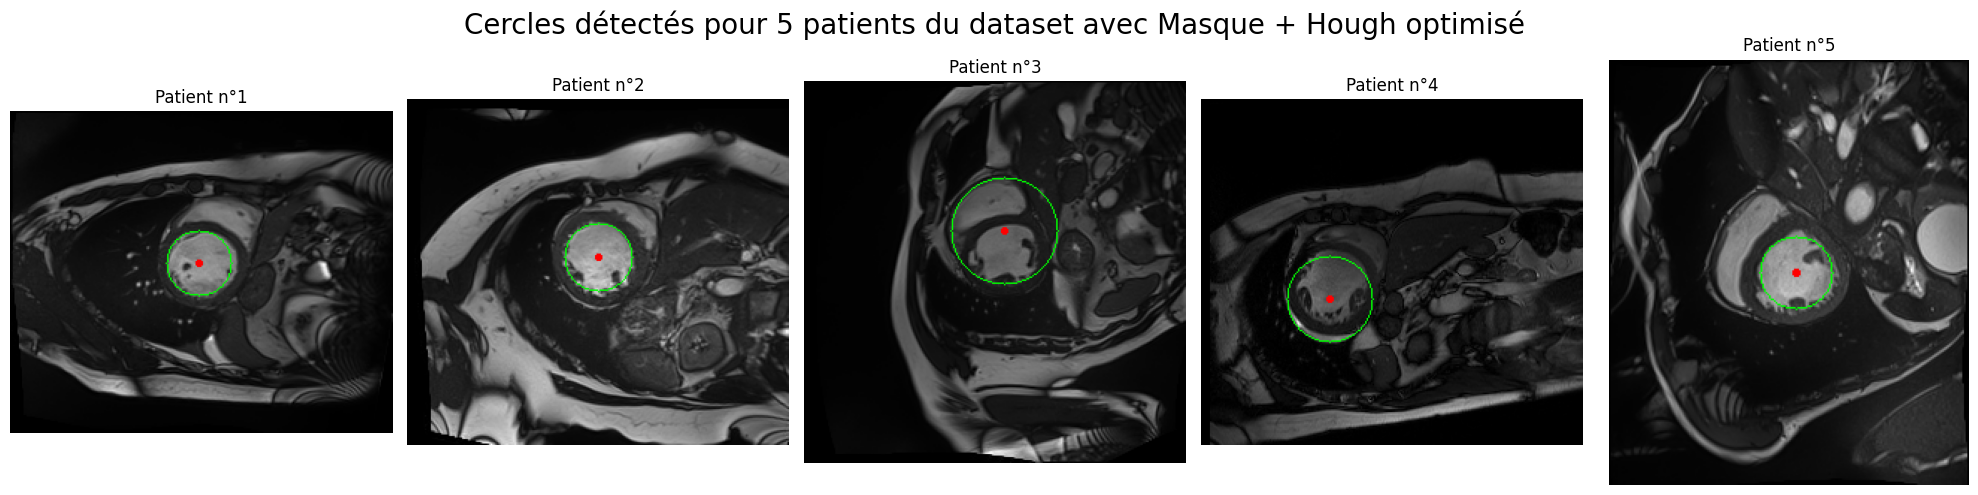

In [94]:
def hough_appercu(n1,n2):
    circles_affichage = []
    fig, ax = plt.subplots(1, n2-n1, figsize=(20,5))
    for i in range(n2-n1):
        patient = load_patient(n1+i)
        t_img = torch.tensor(patient.img.data, dtype=torch.float32)
        hr = t_img.shape[0] / (patient.info["ES"] - patient.info["ED"])
        img_m = tf_mask(t_img, heartrate=hr, Tps=Tps, Slice=Slice)
        img_m = np.array(img_m[0], dtype=np.uint8)
        circles = best_hough(img_m)
        circles_affichage.append(circles)
        cimg = draw_cercles(t_img, circles_affichage[i], Tps, Slice)
        ax[i].imshow(cimg)
        ax[i].set_title(f'Patient n°{i+n1}')
        ax[i].axis('off')
    plt.suptitle('Cercles détectés pour 5 patients du dataset avec Masque + Hough optimisé', fontsize=20)
    plt.tight_layout()
    plt.show()

hough_appercu(1,6)

In [95]:
def find_seed(patient, Tps=Tps, Slice=Slice):
    # first create the image masked and then performs a Hough Transform
    t_img = torch.tensor(patient.img.data, dtype=torch.float32)
    hr = t_img.shape[0] / (patient.info["ES"] - patient.info["ED"])
    img_m, _ = tf_mask(t_img, heartrate=hr, Tps=Tps, Slice=Slice)
    circles = best_hough(img_m)
    return circles

In [96]:
def patient_metrics(patient, circles, Slice=Slice):
    # this give 3 metrics: (1: circle found ?   2: distance between center and groundtruth   3: center in the LV ?)
    t_gt = torch.tensor(patient.gt.data)
    center = (t_gt[0, :, :, Slice]==3).argwhere().mean(axis=0, dtype=torch.float32)
    if circles is None:
        return False, 0., False
    
    dist = torch.dist(center, torch.tensor(circles[:2])) 
    gt_map = torch.tensor(patient.gt.data, dtype=torch.int32)
    hit =  (gt_map[0, int(circles[1]), int(circles[0]), Slice] == 3)

    return True, dist, hit

In [97]:

avg_dist = 0
miss = 0
accuracie = 0
nb = 50
for i in range (1,nb+1):
    patient = load_patient(i, testing=True)
    t_img = torch.tensor(patient.img.data, dtype=torch.float32)
    slice = t_img.shape[3] // 2
    circles = find_seed(patient, Slice=slice)
    c_img = draw_cercles(t_img, circles, Slice=slice)
    found, dist, hit  = patient_metrics(patient, circles, Slice=slice)

    miss += not found
    avg_dist += dist 
    accuracie += int(hit)
    cv2.imwrite(f'training_seed/cercles_{i:03d}.png', c_img)
avg_dist /= nb - miss

print(f"\n-= results =-\n accuracie: {round(accuracie / nb * 100, 1)}% (over found circles: {round(accuracie / (nb-miss) * 100, 1)})\n miss: {miss} \n avg dist: {avg_dist}\n-===========-")


C:\Users\debat\AppData\Local\Temp\ipykernel_12896\2941608931.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)
C:\Users\debat\AppData\Local\Temp\ipykernel_12896\3848913869.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)
C:\Users\debat\AppData\Local\Temp\ipykernel_12896\506653678.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_map = torch.tensor(patient.gt.data, dtype=torch.int32)



-= results =-
 accuracie: 88.0% (over found circles: 91.7)
 miss: 2 
 avg dist: 43.92428970336914
-===========-


ici évaluer les seed sur le dataset avec finnd seed, puis introduire la métricque, dire qu'on peut mieux faire, in troduire multiple slices, réevaluer et dire bueno.

Cette premiere version de recherche de seed permet de trouver une 

In [98]:
def find_seed_muliple_slices(patient, Tps=Tps):
    seeds = []
    for slice in range(0, patient.img.data.shape[3]):
        seed = find_seed(patient, Tps=Tps, Slice=slice)
        if seed is not None:
            seeds += [seed]
    seeds = np.array(seeds)

    if len(seeds)==0:
        return None
    
    dist = []
    for s in seeds:
        d = seeds - s
        d = d*d 
        dist += [np.sum(d)]

    avg_slice = np.argmin(dist)
    return seeds[avg_slice], avg_slice

In [99]:
avg_dist = 0
miss = 0
accuracie = 0
nb = 100
for i in range (1,nb+1):
    patient = load_patient(i, testing=False)
    t_img = torch.tensor(patient.img.data, dtype=torch.float32)
    circles, slice = find_seed_muliple_slices(patient)
    c_img = draw_cercles(t_img, circles, Slice=slice)
    found, dist, hit  = patient_metrics(patient, circles, Slice=slice)

    miss += not found
    avg_dist += dist 
    accuracie += int(hit)
    if not hit:
        print("miss on patient n°", i)
    cv2.imwrite(f'training_seed/cercles_{i:03d}.png', c_img)
avg_dist /= nb - miss
   
print(f"\n-= results =-\n accuracie: {round(accuracie / nb * 100, 1)}% (over found circles: {round(accuracie / (nb-miss) * 100, 1)})\n miss: {miss} \n avg dist: {avg_dist}\n-===========-")


C:\Users\debat\AppData\Local\Temp\ipykernel_12896\1422122817.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)
C:\Users\debat\AppData\Local\Temp\ipykernel_12896\3848913869.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)
C:\Users\debat\AppData\Local\Temp\ipykernel_12896\506653678.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_map = torch.tensor(patient.gt.data, dtype=torch.int32)


miss on patient n° 6
miss on patient n° 23
miss on patient n° 24
miss on patient n° 26
miss on patient n° 30
miss on patient n° 37
miss on patient n° 69
miss on patient n° 86
miss on patient n° 92
miss on patient n° 93

-= results =-
 accuracie: 90.0% (over found circles: 90.0)
 miss: 0 
 avg dist: nan
-===========-


il reste à faire l'évaluation des performances sur l'ensemble du dataset avec la gt.

plus

L'image qui pose probleme et la solution ?

## 4. Segmentation du ventricule gauche

Une fois une seed correctement placée au centre du ventricule gauche, nous pouvons chercher à segmenter ce dernier en utilisant une approche par croissance de région.

### A. Segmentation par croissance de région

Le principe de la segmentation par croissance de région est simple et peut être décrit par les étapes suivantes :
- **Initialisation** : On initalise la région comme vide. On marque tous les pixels de l'image comme non explorés, et on ajoute la seed (non explorée) à la région. On détermine un *treshold* qui sera le critère d'arret de notre segmentation.
- **Tant qu'il existe** des pixels de la région marqués comme non explorés:
    - on choisit l'un de ces pixels
    - on regarde ses 4 voisins directs. Pour chacun d'entre eux, si la différence en valeur absolue de l'intensité du pixel examiné et de son voisin est inférieure au treshold, on ajoute le voisin à la région.
    - on marque le pixel comme étant examiné.

C'est la région obtenue en sortie de la boucle qui doit correspondre à notre ventricule gauche.

<center>
    <img src="region_growing.jpg" alt="RG" style="width:70%;">
</center>

L'algorithme est assuré de se terminer, puisque le nombre de pixels de l'image est fini, et sa compléxité dans le pire des cas est $O(n^2)$.

## B. Choix du Treshold

L'étape délicate d'une telle méthode de segmentation réside dans le choix du treshold. En effet, observons la segmentation décrite ci dessus pour quelques valeures de treshold différentes.

Pour cela nous définissons la fonction `region_growth`qui reprend l'approche expliquée ci-dessus, à partir d'un treshold fourni en entrée. La fonction retourne la region segmentée sous forme d'une region **connexe** de 1 dans une image de 0, ainsi que la taille de cette région.

In [88]:
def region_growth(image, seed, error=10):
    H,L=image.shape
    
    # estimate mean
    start_moy = []
    for i in range(-2, 3, 1):
        for j in range(-2, 3, 1):
            start_moy += [image[seed[1]+i,seed[0]+j]]
    moy = np.median(start_moy)

    # region growing
    to_explore = deque()
    to_explore.append(np.array(seed))

    dxy = np.array([[0,-1],[-1,0],[1,0],[0,1]])

    left_V = np.zeros_like(image)
    valide = (moy - image < error)
    valide[0, :] = False 
    valide[H-1, :] = False
    valide[:, 0] = False 
    valide[:, L-1] = False
    while to_explore:
        pos = to_explore.popleft()
        x, y = pos
        if valide[y, x] and not left_V[y, x]:
            left_V[y, x] = 1
            for p in dxy + pos:
                to_explore.append(p)
        
    taille = np.sum(left_V)
    return left_V, taille


On peut ainsi obvserver la segmentation produite, pour 3 valeurs de tresholds. 
$$treshold = [8,30,55]$$
Le résultat est le suivant.

C:\Users\maell\AppData\Local\Temp\ipykernel_15932\489272083.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_1, img_2 = torch.tensor(patient_1.img.data, dtype=torch.float32), torch.tensor(patient_2.img.data, dtype=torch.float32)
C:\Users\maell\AppData\Local\Temp\ipykernel_15932\3529931855.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)


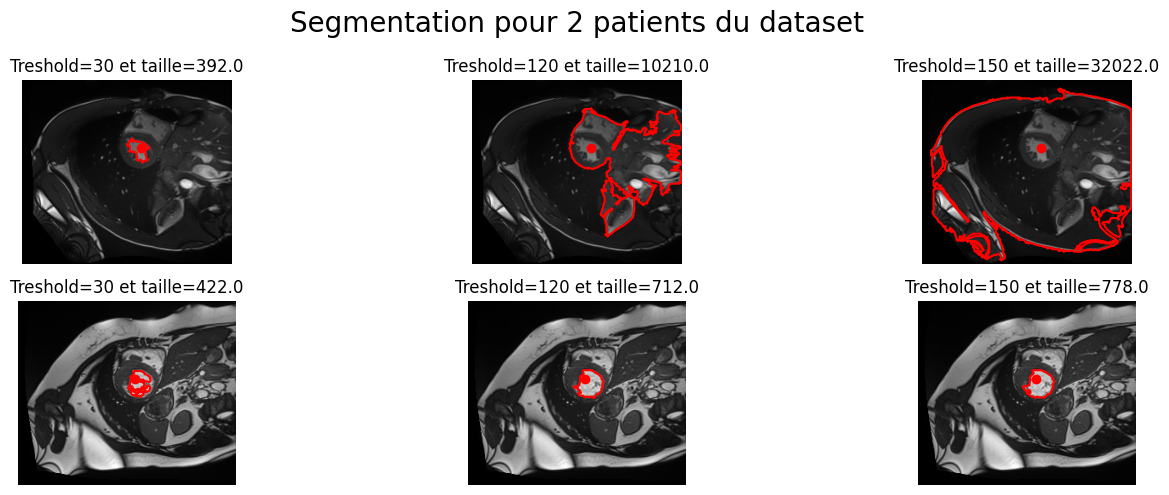

In [95]:
tresholds = [30,120,150]

patient_1, patient_2 = load_patient(Numero_patient), load_patient(Numero_patient+5)
img_1, img_2 = torch.tensor(patient_1.img.data, dtype=torch.float32), torch.tensor(patient_2.img.data, dtype=torch.float32)
seed_1, seed_2 = find_seed(patient_1), find_seed(patient_2)
seed_int_1, seed_int_2 = (int(seed_1[0]), int(seed_1[1])), (int(seed_2[0]), int(seed_2[1]))
fig, ax = plt.subplots(2, 3, figsize=(15,5))
for t in tresholds:
    lv_seg_1, taille_1 = region_growth(img_1[Tps, :, :, Slice], seed_int_1, error=t)
    lv_seg_2, taille_2 = region_growth(img_2[Tps, :, :, Slice], seed_int_2, error=t)
    contours_1 = measure.find_contours(lv_seg_1, 0.5)
    contours_2 = measure.find_contours(lv_seg_2, 0.5)
    ax[0, tresholds.index(t)].imshow(patient_1.img.data[Tps, :, :, Slice], cmap='gray')
    ax[0, tresholds.index(t)].plot(seed_1[0], seed_1[1], 'ro')
    ax[0, tresholds.index(t)].plot(contours_1[0][:, 1], contours_1[0][:, 0], 'r')
    ax[0, tresholds.index(t)].set_title(f'Treshold={t} et taille={taille_1}')
    ax[0, tresholds.index(t)].axis('off')
    ax[1, tresholds.index(t)].imshow(patient_2.img.data[Tps, :, :, Slice], cmap='gray')
    ax[1, tresholds.index(t)].plot(seed_2[0], seed_2[1], 'ro')
    ax[1, tresholds.index(t)].plot(contours_2[0][:, 1], contours_2[0][:, 0], 'r')
    ax[1, tresholds.index(t)].set_title(f'Treshold={t} et taille={taille_2}')
    ax[1, tresholds.index(t)].axis('off')
plt.suptitle('Segmentation pour 2 patients du dataset', fontsize=20)
plt.tight_layout()
plt.show()


Pour deux patients différent du dataset, les tresholds optimaux sont différents. En effet pour le patient n°28, la région segmentée explose au dela de 120, tandis que pour le patient n°33, un treshold de 150 ne suffit toujours pas à faire exploser la région.

Cela est du à la luminosité des différentes images et met en évidence un point important : il nous faut régler le treshold en fonction de chaque patient.

Nous proposons donc l'approche suivante :


In [96]:
def leftv_seg(img, full_seed, Tps=Tps, Slice=Slice):
    if full_seed is None:
        return None
    
    seed = [int(full_seed[0]), int(full_seed[1])]
    rayon = full_seed[2]

    xx, yy = np.mgrid[:img.shape[0], :img.shape[1]]
    circle = (xx - seed[1]) ** 2 + (yy - seed[0]) ** 2
    circle_map = np.zeros(img.shape, np.bool_)
    circle_map[circle < rayon*rayon] = True

    treshold = 0
    dices = []

    step = 5
    for treshold in range(5, 150, step):
        lv_seg, taille_1 = region_growth(np.array(img), seed, treshold)
        lv_seg = np.bool_(lv_seg)
        
        inter = np.sum(lv_seg & circle_map)
        diff_ext = np.sum(lv_seg & np.logical_not(circle_map))
        dice =  (2*inter-diff_ext) / (np.sum(lv_seg) + np.sum(circle_map))
        dices += [(dice, treshold)]

    treshold = max(dices)[1]
    lv_seg, taille_1 = region_growth(np.array(img), seed, treshold)

    lv_out = cv2.dilate(lv_seg, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(59,59)), 1)
    lv_out = cv2.erode(lv_out, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(59,59)), 1)
    return lv_out

In [100]:
def dice(patient, lv_seg, Slice=Slice):
    t_gt = torch.tensor(patient.gt.data)
    gt_map = t_gt[0, :, :, Slice]
    gt_map = (gt_map == 3)

    lv_seg = np.bool_(lv_seg)
    gt_map = np.bool_(gt_map)
    inter = np.sum(lv_seg & gt_map)
    
    return 2*inter / (np.sum(lv_seg) + np.sum(gt_map))

In [97]:
def draw_region(imageRGB, lv_seg):
    le_contour = lv_seg - cv2.erode(lv_seg, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), 1, borderType=cv2.BORDER_CONSTANT, borderValue=0)
    lv_seg = np.bool_(lv_seg)
    le_contour = np.bool_(le_contour)
    imageRGB[lv_seg, 2] = 100
    imageRGB[le_contour, 2] = 255
    return imageRGB

In [98]:
def recherche_lv(nb):
    avg_dist = 0
    miss = 0
    accuracie = 0
    rad = []
    avg_dice = 0
    for i in range (1,nb+1):
        patient = load_patient(i)
        t_img = torch.tensor(patient.img.data, dtype=torch.float32)
        t_gt = torch.tensor(patient.gt.data, dtype=torch.float32)
        sslice = t_img.shape[3] // 2
        circles, _ = find_seed_muliple_slices(patient)
        lv_seg = leftv_seg(patient, Slice=sslice)
        if lv_seg is None:
            miss += 1
            continue
        c_img = draw_cercles(t_img, circles, Slice=sslice)
        c_img = draw_region(c_img, lv_seg)
        found, dist, hit  = patient_metrics(patient, circles, Slice=sslice)

        miss += not found
        avg_dist += dist 
        accuracie += int(hit) 

        cv2.imwrite(f'training_segmentation/cercles_{i:03d}.png', c_img)
        dice_score = dice(patient, lv_seg, sslice)
        avg_dice += dice_score
        if dice_score < 0.2:
            print(f"{i} : {found} {dist} {hit} and Dice: {dice_score}")
    avg_dist /= nb - miss
    avg_dice /= nb
    print(f"\n-= results =-\n accuracie: {round(accuracie / nb * 100, 1)}% (over found circles: {round(accuracie / (nb-miss) * 100, 1)})\n miss: {miss} \n avg dist: {avg_dist}\n avg dice: {avg_dice}\n-===========-")


3. Croissance de région.
    - algorithme de base
    - quand s'aretter ?
    - méthode complete de segmentation du ventricule gauche
    - métrics : performance
4. Propagation des seeds: étape nécessaire avant la passage au volume
    - comment propager seed sur ses voisins.
5. Passage au volume
    - methode et resultats
    - performances
6. Resultats finaux
    - affichage de nos résultats, performance.
    - choses à améliorer ?
